# FCN with ResNet50 model
### Segmentation method

## Get packages

In [31]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.models import Model
from keras.layers import (Input, Activation, Reshape, Conv2D, Lambda, Add)
import tensorflow as tf
import tensorflow as tf

from tqdm import tqdm
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize

## Paths and size

In [2]:
TRAIN_PATH = 'archive/segmentation/train/'
TEST_PATH = 'archive/segmentation/test/'

seed = 42
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [36]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

## Load and Prepare Images

In [37]:

# print('Resizing training images and masks')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent = {}

#train images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img
    correspondent[n] = str(id_)

# #train masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask_

# # test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

size_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_test[n] = mask_
print('Done!')

100%|█████████████████████████████████████████| 720/720 [00:22<00:00, 31.33it/s]


Resizing test images


100%|█████████████████████████████████████████| 216/216 [00:06<00:00, 31.72it/s]

Done!


## Make the model

In [14]:
# Import ResNet50
from keras.applications.resnet50 import ResNet50

In [24]:
conv_base = ResNet50()
print(conv_base.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [41]:
def make_fcn_resnet(input_shape, nb_labels, use_pretraining, freeze_base):
    nb_rows, nb_cols, _ = input_shape
    input_tensor = Input(shape=input_shape)
    weights = 'imagenet' if use_pretraining else None
    
# A ResNet model with weights from training on ImageNet. This will
# be adapted via graph surgery into an FCN.
    model = ResNet50(
        include_top=False, weights=weights, input_tensor=input_tensor)

    if freeze_base:
        for layer in model.layers:
            layer.trainable = False
            
#  Get final 32x32, 16x16, and 8x8 layers in the original
# ResNet by that layers's name.
    x32 = model.get_layer('conv3_block4_out').output 
    x16 = model.get_layer('conv4_block6_out').output 
    x8 = model.get_layer('conv5_block3_out').output 
    
    
# Compress each skip connection so it has nb_labels channels.
    c32 = Conv2D(nb_labels, (1, 1), name='conv_labels_32')(x32)
    c16 = Conv2D(nb_labels, (1, 1), name='conv_labels_16')(x16)
    c8 = Conv2D(nb_labels, (1, 1), name='conv_labels_8')(x8)
    
# Resize each compressed skip connection using bilinear interpolation.
# This operation isn't built into Keras, so we use a LambdaLayer
# which allows calling a Tensorflow operation.
    def resize_bilinear(images):
        return tf.compat.v1.image.resize_bilinear(images, [nb_rows, nb_cols])

    r32 = Lambda(resize_bilinear, name='resize_labels_32')(c32)
    r16 = Lambda(resize_bilinear, name='resize_labels_16')(c16)
    r8 = Lambda(resize_bilinear, name='resize_labels_8')(c8)
    
# Merge the three layers together using summation.
    m = Add(name='merge_labels')([r32, r16, r8])
    
# Add softmax layer to get probabilities as output. We need to reshape
# and then un-reshape because Keras expects input to softmax to
# be 2D.
    x = Reshape((nb_rows * nb_cols, nb_labels))(m)
    x = Activation('sigmoid')(x)
    x = Reshape((nb_rows, nb_cols, nb_labels))(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model

In [42]:

model = make_fcn_resnet([256, 256, 3], 1,
                        use_pretraining=True, freeze_base=False)

In [ ]:
nb_labels = 1
nb_cols = 256
nb_rows = 256
nb_bands = 3

input_tensor = Input((nb_rows, nb_cols, nb_bands))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_11[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [45]:
# Se antreneaza modelul
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_FCN_ResNet50.h5', verbose=1, save_best_only=True)

callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpoiter

]
results = model.fit(X_train, 
                    Y_train, 
                    validation_split=0.1, 
                    batch_size=8, 
                    epochs=25, 
                    callbacks=callbacks
                   )


Epoch 1/25
81/81 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9125
Epoch 1: val_loss improved from inf to 1.55275, saving model to model_FCN_ResNet50.h5


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 191s 2s/step - loss: 0.2303 - accuracy: 0.9125 - val_loss: 1.5528 - val_accuracy: 0.8840
Epoch 2/25
81/81 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.9409
Epoch 2: val_loss improved from 1.55275 to 0.20873, saving model to model_FCN_ResNet50.h5
81/81 [==============================] - 199s 2s/step - loss: 0.1438 - accuracy: 0.9409 - val_loss: 0.2087 - val_accuracy: 0.9303
Epoch 3/25
81/81 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9563
Epoch 3: val_loss improved from 0.20873 to 0.19406, saving model to model_FCN_ResNet50.h5
81/81 [==============================] - 190s 2s/step - loss: 0.1066 - accuracy: 0.9563 - val_loss: 0.1941 - val_accuracy: 0.9309
Epoch 4/25
81/81 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9681
Epoch 4: val_loss did not improve from 0.19406
81/81 [==============================] - 191s 2s/step - loss: 0.0775 - accuracy: 0.9681 - val_loss: 0

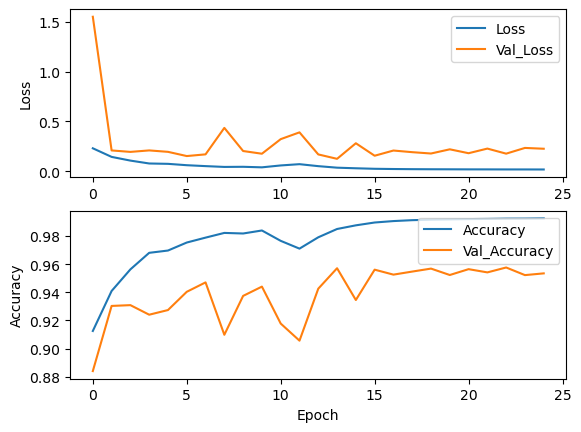

In [46]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [47]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


7/7 [==============================] - 20s 3s/step


In [48]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.9576365351676941
Loss Score =  0.12428715825080872


Image number:  25


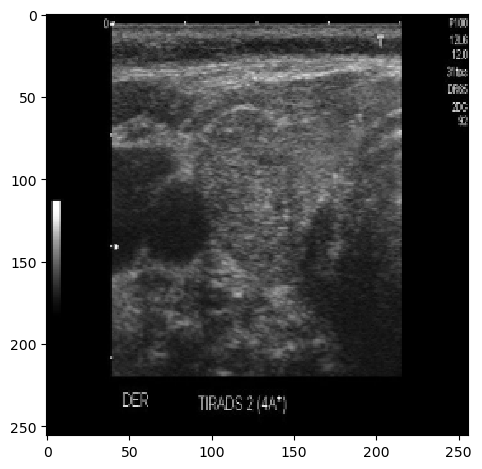

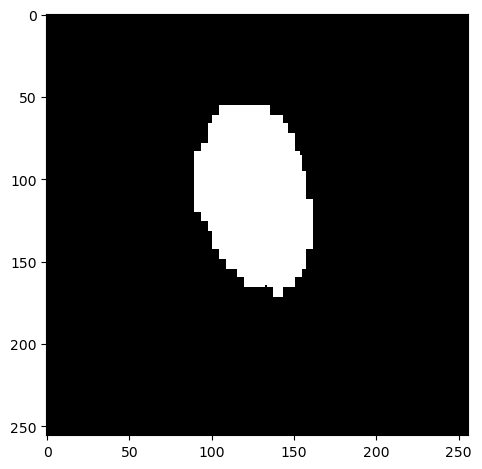

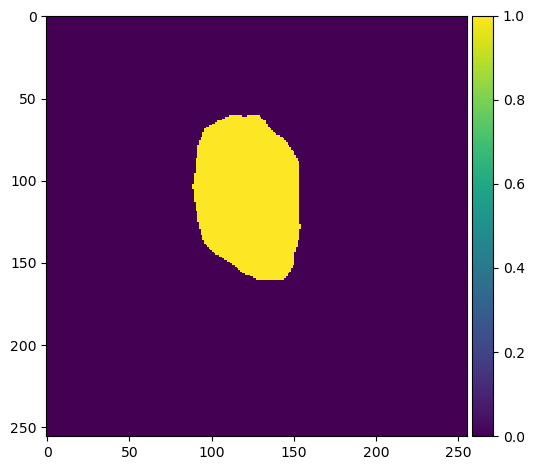

In [50]:
x = random.randint(0, len(preds_test_t))

print("Image number: ",x)
imshow(X_test[x])
plt.show()
imshow(np.squeeze(Y_test[x]))
plt.show()
imshow(np.squeeze(preds_test_t[x]))
plt.show()


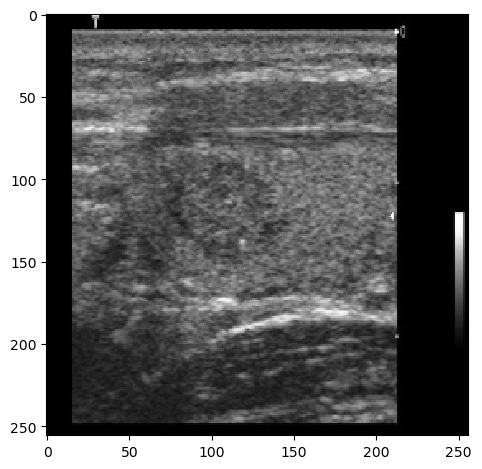

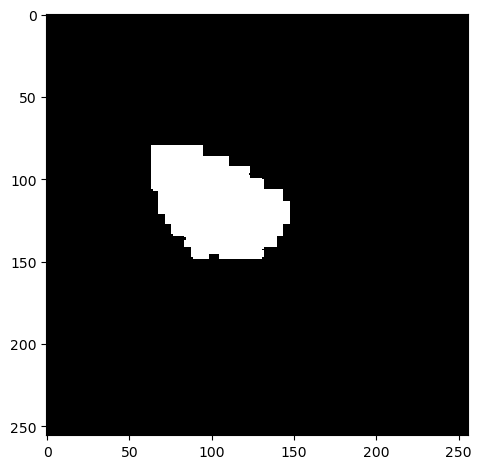

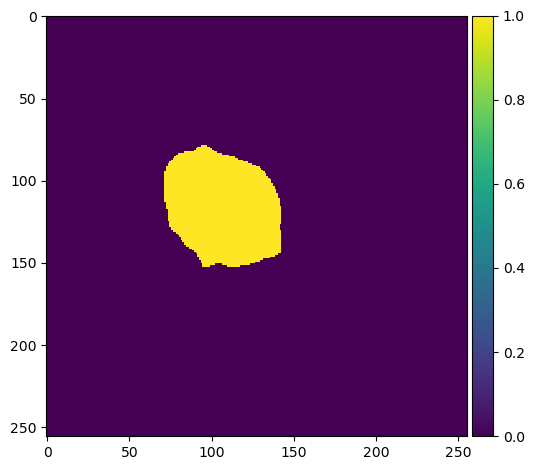

Image number:  67


NameError: name 'sns' is not defined

<Figure size 600x600 with 0 Axes>

In [51]:

# Se alege un numar aleator    
x = random.randint(0, len(preds_test_t))

# Se afiseaza imaginea impreuna cu masca si predictia
imshow(X_test[x])
plt.show()
imshow(np.squeeze(Y_test[x]))
plt.show()
imshow(np.squeeze(preds_test_t[x]))
plt.show()
print("Image number: ",x)

gtMask = Y_test[x]
predMask = preds_test_t[x]   

# Get the parameters value 
tp = 0
fp = 0
fn = 0
tn = 0

for i in range(len(gtMask)):
    for j in range(len(gtMask[i])):
        if gtMask[i][j] == True and predMask[i][j] == 1:
            tp += 1
        elif gtMask[i][j] == False and predMask[i][j] == 1:
            fp += 1
        elif gtMask[i][j] == True and predMask[i][j] == 0:
            fn += 1
        elif gtMask[i][j] == False and predMask[i][j] == 0:
            tn += 1

# Show the Confusion Matrix          
cmat = [[tp, fn], [fp, tn]]
plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("predictions")
plt.ylabel("real values")
plt.show()

# Print parameters
print("True positive: ",tp)
print("False positive: ",fp)
print("False negative: ",fn)
print("True negative: ",tn)

# Calculate the evaluation metrics
iou = tp / (tp + fp + fn)
total = tp + fp + fn + tn
accuracy = (tp + tn) / total
f1_score = (2 * tp) / ((2 * tp) + fp + fn)
mcc = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

# Print the evaluation metrics
print("MCC: ", round(mcc*100, 3), "%")
print("F1: ", round(f1_score*100, 3), "%")
print("Acc: ", round(accuracy*100, 3), "%")    
print("IoU: ", round(iou*100, 3), "%")
